# Benchmarking Auto-Completion Models

This notebook compares various representations of the same model in order to investigate the benefits of quantisation and other optimisations, comparing performance of CPU- and GPU-based execution.

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from time import time

import numpy as np
import pandas as pd
import torch.cuda

from autodev.util import logging
from autodev.autocomplete.completion_model import CompletionModel
from autodev.autocomplete.completion_task import CompletionTask
from autodev.autocomplete.model import SantaCoderModelFactory, ModelTransformationBetterTransformer, \
    ModelTransformation
from autodev.util.resource_usage import ResourceUsageMonitoringThread

log = logging.getLogger(__name__)
logging.configure()

/home/d_jain_appliedai_de/remote-autodev/autodev/__init__.py:58: UserWarning: Patching transformers.TextGenerationPipeline._forward because of a bug that requires all pipeline arguments to be serializable.
  warnings.warn("Patching transformers.TextGenerationPipeline._forward because of a bug that requires all pipeline arguments to be serializable.")


In [4]:
# configuration parameters
num_applications = 5
num_burnin_applications = 1

In [12]:
# load completion tasks
prefix = "def add(x, y):\n"
completion_tasks = [CompletionTask.from_file(p, "python") for p in Path("data/completion-tasks/python").iterdir()]
log.info(f"{len(completion_tasks)} completion tasks loaded")

INFO  2023-07-18 14:41:37,301 __main__:<module> - 2 completion tasks loaded


In [13]:
# define models to be benchmarked
mf = SantaCoderModelFactory()
tokenizer = mf.create_tokenizer()

def create_model(path, device, nocache=False, transform: ModelTransformation = None):
    model = mf.create_model(path, transformation=transform)
    if nocache:
        if model.config.use_cache:
            model.config.use_cache = False
        else:
            raise ValueError("Model does not use cache to begin with")
    return CompletionModel(model, tokenizer, device=device)

transformers_model_path = "bigcode/santacoder"
onnx_model_path = "models/santacoder_onnx"
onnx_avx2_model_path = "models/santacoder_onnx_avx2"
onnx_avx512_model_path = "models/santacoder_onnx_avx512"
onnx_avx512_vnni_model_path = "models/santacoder_onnx_avx512-vnni"
bt = ModelTransformationBetterTransformer()
models = {
    "transformers-cached-cpu": (lambda: create_model(transformers_model_path, "cpu")),
    "transformers-cpu": (lambda: create_model(transformers_model_path, "cpu", nocache=True)),
    "onnxruntime-cpu": (lambda: create_model(onnx_model_path, "cpu")),
    #"onnxruntime-cpu-avx2": (lambda: create_model(onnx_avx2_model_path, "cpu")),
    "onnxruntime-cpu-avx512": (lambda: create_model(onnx_avx512_model_path, "cpu")),
    "onnxruntime-cpu-avx512-vnni": (lambda: create_model(onnx_avx512_vnni_model_path, "cpu")),
    "bettertransformer-cached-cpu": (lambda: create_model(transformers_model_path, "cpu", transform=bt)),
}
if torch.cuda.is_available():
    device = "cuda:0"
    models.update({
        "transformers-cached-gpu": (lambda: create_model(transformers_model_path, device)),
        "transformers-gpu": (lambda: create_model(transformers_model_path, device, nocache=True)),
        "onnxruntime-gpu": (lambda: create_model(onnx_model_path, device)),
        "bettertransformer-cached-gpu": (lambda: create_model(transformers_model_path, device, transform=bt)),
    })

In [14]:
# apply benchmarking
monitoring_thread = ResourceUsageMonitoringThread()
monitoring_thread.start()
rows = []
for model_name, cm_factory in models.items():
    log.info(f"Starting evaluation of {model_name}")
    tstart = time()
    completion_model: CompletionModel = cm_factory()
    load_time = time() - tstart
    num_chars = 0
    for i in range(num_applications + num_burnin_applications):
        if i == num_burnin_applications:
            monitoring_thread.begin_collection(model_name)
            tstart = time()
            num_chars = 0
        for completion_task in completion_tasks:
            result = completion_model.apply(completion_task)
            num_chars += len(result.completion)
    time_taken = time() - tstart
    log.info(f"{model_name}: time taken = {time_taken}s")
    resource_usage = monitoring_thread.end_collection()
    row = dict(model_name=model_name, time_taken=time_taken, num_chars=num_chars,
        secs_per_task=time_taken/(num_applications*len(completion_tasks)), load_time=load_time,
        cpu_usage=resource_usage.cpu_utilization_percent(agg=np.median),
        gpu_usage=resource_usage.gpu_utilization_percent(agg=np.median),
        ram_gb=resource_usage.system_memory_usage_mb(agg=np.median) / 1000,
        vram_gb=resource_usage.gpu_memory_usage_mb(agg=np.median) / 1000)
    log.info(f"{row}")
    rows.append(row)
    del completion_model

INFO  2023-07-18 14:42:49,257 __main__:<module> - Starting evaluation of transformers-cached-cpu


The model 'GPT2LMHeadCustomModel' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausalLM', 'RobertaPreLayer

INFO  2023-07-18 14:43:33,220 __main__:<module> - transformers-cached-cpu: time taken = 24.627246379852295s
INFO  2023-07-18 14:43:33,222 __main__:<module> - {'model_name': 'transformers-cached-cpu', 'time_taken': 24.627246379852295, 'num_chars': 720, 'secs_per_task': 2.4627246379852297, 'load_time': 14.89493465423584, 'cpu_usage': 51.4, 'gpu_usage': 0.0, 'ram_gb': 6.534232064, 'vram_gb': 0.002}
INFO  2023-07-18 14:43:33,237 __main__:<module> - Starting evaluation of transformers-cpu


The model 'GPT2LMHeadCustomModel' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausalLM', 'RobertaPreLayer

INFO  2023-07-18 14:45:38,378 __main__:<module> - transformers-cpu: time taken = 93.03716254234314s
INFO  2023-07-18 14:45:38,380 __main__:<module> - {'model_name': 'transformers-cpu', 'time_taken': 93.03716254234314, 'num_chars': 720, 'secs_per_task': 9.303716254234313, 'load_time': 13.892664670944214, 'cpu_usage': 51.7, 'gpu_usage': 0.0, 'ram_gb': 8.190898176, 'vram_gb': 0.002}
INFO  2023-07-18 14:45:38,395 __main__:<module> - Starting evaluation of onnxruntime-cpu
INFO  2023-07-18 14:45:38,396 autodev.autocomplete.model:create_model - Loading ONNX model from models/santacoder_onnx/model.onnx
INFO  2023-07-18 14:47:24,097 __main__:<module> - onnxruntime-cpu: time taken = 77.54898881912231s
INFO  2023-07-18 14:47:24,099 __main__:<module> - {'model_name': 'onnxruntime-cpu', 'time_taken': 77.54898881912231, 'num_chars': 720, 'secs_per_task': 7.754898881912231, 'load_time': 7.278679847717285, 'cpu_usage': 51.7, 'gpu_usage': 0.0, 'ram_gb': 7.3256591360000005, 'vram_gb': 0.002}
INFO  2023-

The model 'GPT2LMHeadCustomModel' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausalLM', 'RobertaPreLayer

INFO  2023-07-18 14:49:23,809 __main__:<module> - bettertransformer-cached-cpu: time taken = 25.515854358673096s
INFO  2023-07-18 14:49:23,811 __main__:<module> - {'model_name': 'bettertransformer-cached-cpu', 'time_taken': 25.515854358673096, 'num_chars': 720, 'secs_per_task': 2.5515854358673096, 'load_time': 13.894367933273315, 'cpu_usage': 51.4, 'gpu_usage': 0.0, 'ram_gb': 7.838355456, 'vram_gb': 0.002}
INFO  2023-07-18 14:49:23,811 __main__:<module> - Starting evaluation of transformers-cached-gpu


The model 'GPT2LMHeadCustomModel' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausalLM', 'RobertaPreLayer

INFO  2023-07-18 14:49:46,289 __main__:<module> - transformers-cached-gpu: time taken = 4.928380489349365s
INFO  2023-07-18 14:49:46,291 __main__:<module> - {'model_name': 'transformers-cached-gpu', 'time_taken': 4.928380489349365, 'num_chars': 720, 'secs_per_task': 0.49283804893493655, 'load_time': 15.873294591903687, 'cpu_usage': 9.3, 'gpu_usage': 34.0, 'ram_gb': 9.244991488, 'vram_gb': 5.677}
INFO  2023-07-18 14:49:46,292 __main__:<module> - Starting evaluation of transformers-gpu


The model 'GPT2LMHeadCustomModel' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausalLM', 'RobertaPreLayer

INFO  2023-07-18 14:50:08,926 __main__:<module> - transformers-gpu: time taken = 6.212313413619995s
INFO  2023-07-18 14:50:08,927 __main__:<module> - {'model_name': 'transformers-gpu', 'time_taken': 6.212313413619995, 'num_chars': 720, 'secs_per_task': 0.6212313413619995, 'load_time': 15.163747310638428, 'cpu_usage': 9.4, 'gpu_usage': 72.0, 'ram_gb': 11.191875584, 'vram_gb': 5.801}
INFO  2023-07-18 14:50:08,929 __main__:<module> - Starting evaluation of onnxruntime-gpu
INFO  2023-07-18 14:50:08,930 autodev.autocomplete.model:create_model - Loading ONNX model from models/santacoder_onnx/model.onnx


2023-07-18 14:50:13.847814908 [W:onnxruntime:, session_state.cc:1169 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2023-07-18 14:50:13.847852251 [W:onnxruntime:, session_state.cc:1171 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
/opt/conda/envs/autodev/lib/python3.10/site-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/opt/conda/envs/autodev/lib/python3.10/site-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


INFO  2023-07-18 14:50:21,085 __main__:<module> - onnxruntime-gpu: time taken = 3.7630276679992676s
INFO  2023-07-18 14:50:21,086 __main__:<module> - {'model_name': 'onnxruntime-gpu', 'time_taken': 3.7630276679992676, 'num_chars': 720, 'secs_per_task': 0.37630276679992675, 'load_time': 7.631702899932861, 'cpu_usage': 9.4, 'gpu_usage': 56.5, 'ram_gb': 11.20289792, 'vram_gb': 14.317}
INFO  2023-07-18 14:50:21,087 __main__:<module> - Starting evaluation of bettertransformer-cached-gpu
WARNING 2023-07-18 14:50:34,855 root:transform - For training, the BetterTransformer implementation for gpt2  architecture currently does not support padding as fused kernels do not support custom attention masks. Beware that passing padded batched training data may result in unexpected outputs.


The model 'GPT2LMHeadCustomModel' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausalLM', 'RobertaPreLayer

INFO  2023-07-18 14:50:41,792 __main__:<module> - bettertransformer-cached-gpu: time taken = 4.923989772796631s
INFO  2023-07-18 14:50:41,793 __main__:<module> - {'model_name': 'bettertransformer-cached-gpu', 'time_taken': 4.923989772796631, 'num_chars': 720, 'secs_per_task': 0.4923989772796631, 'load_time': 14.802172422409058, 'cpu_usage': 8.8, 'gpu_usage': 34.0, 'ram_gb': 12.871528448, 'vram_gb': 6.093}


In [15]:
df = pd.DataFrame(rows).sort_values("secs_per_task").reset_index()
df

,index,model_name,time_taken,num_chars,secs_per_task,load_time,cpu_usage,gpu_usage,ram_gb,vram_gb
0,8,onnxruntime-gpu,3.763028,720,0.376303,7.631703,9.4,56.5,11.202898,14.317
1,9,bettertransformer-cached-gpu,4.923990,720,0.492399,14.802172,8.8,34.0,12.871528,6.093
2,6,transformers-cached-gpu,4.928380,720,0.492838,15.873295,9.3,34.0,9.244991,5.677
3,7,transformers-gpu,6.212313,720,0.621231,15.163747,9.4,72.0,11.191876,5.801
4,0,transformers-cached-cpu,24.627246,720,2.462725,14.894935,51.4,0.0,6.534232,0.002
5,5,bettertransformer-cached-cpu,25.515854,720,2.551585,13.894368,51.4,0.0,7.838355,0.002
6,3,onnxruntime-cpu-avx512,26.270535,720,2.627053,6.392890,51.4,0.0,9.912439,0.002
7,4,onnxruntime-cpu-avx512-vnni,26.728214,720,2.672821,6.458055,52.0,0.0,12.337623,0.002
8,2,onnxruntime-cpu,77.548989,720,7.754899,7.278680,51.7,0.0,7.325659,0.002
9,1,transformers-cpu,93.037163,720,9.303716,13.892665,51.7,0.0,8.190898,0.002


<Axes: xlabel='secs_per_task', ylabel='model_name'>

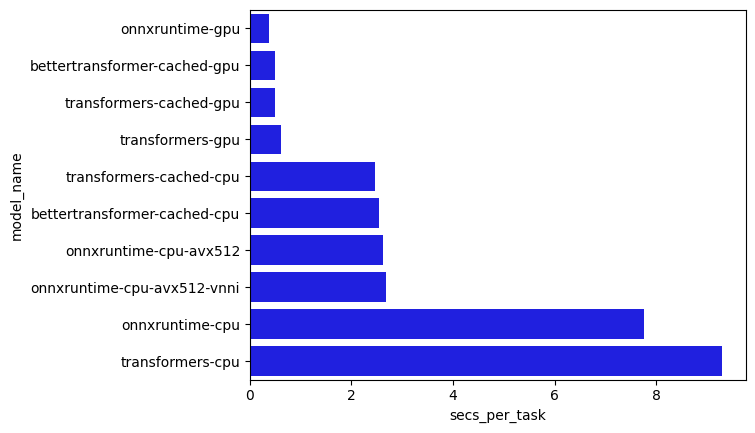

In [29]:
import seaborn as sns

sns.barplot(x="secs_per_task", y="model_name", data=df, color="blue")

<Axes: xlabel='memory (GB)', ylabel='model_name'>

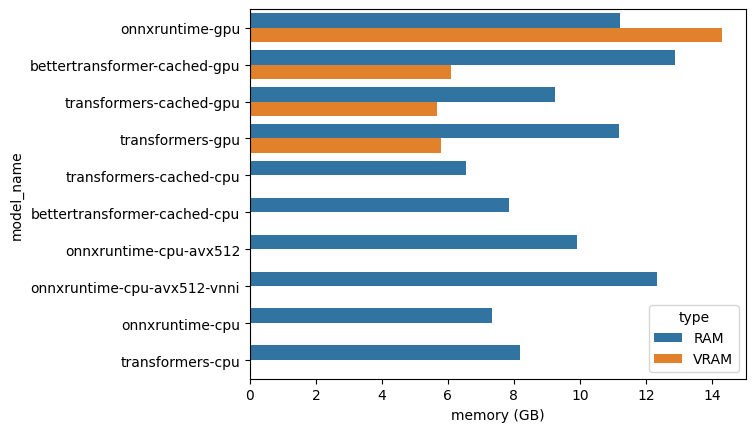

In [28]:
df_ram = df[["ram_gb", "model_name"]].rename(columns={"ram_gb": "memory (GB)"})
df_ram["type"] = "RAM"
df_vram = df[["vram_gb", "model_name"]].rename(columns={"vram_gb": "memory (GB)"})
df_vram["type"] = "VRAM"
df_mem = pd.concat([df_ram, df_vram])
sns.barplot(x="memory (GB)", y="model_name", hue="type", data=df_mem)